In [1]:
from noise import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
%matplotlib widget

In [2]:
starti = 38
endi = 42

In [3]:
counters = ['bardeen','bell','curie','feynman','newton','noether','rossi','rubin']
# counters = ['bell','curie','feynman','newton','noether','rossi','rubin']
noise_open_dict = {}
noise_closed_dict = {}
fadc_open_dict = {}
fadc_closed_dict = {}
diff_dict = {}
removed_murmur_dict = {}
freq = freq_mhz()
pos_freq = freq[freq>0]
date = '20240413'
openfile =  f'{date}072456.bg.bin'
closedfile =f'{date}072416.bg.bin'
for counter in counters:
    p_open = Path(f'/home/isaac/niche_data/{date}/{counter}/{openfile}')
    p_closed = Path(f'/home/isaac/niche_data/{date}/{counter}/{closedfile}')
    noise_open = read_noise_file(p_open).astype('float')
    # noise_open -= noise_open.mean()
    noise_closed = read_noise_file(p_closed).astype('float')
    # noise_closed -= noise_closed.mean()
    fadc_open_dict[counter] = noise_open
    fadc_closed_dict[counter] = noise_closed
    noise_open_dict[counter] = noise_fft(noise_open)**2
    noise_closed_dict[counter] = noise_fft(noise_closed)**2
    diff_dict[counter] = noise_open_dict[counter] - noise_closed_dict[counter]
    removed_murmur = diff_dict[counter][freq>0.]
    removed_murmur[:starti] = removed_murmur[starti:endi].mean()
    removed_murmur_dict[counter] = np.concatenate(([diff_dict[counter][0]],removed_murmur,[diff_dict[counter][512]],removed_murmur[::-1]))

[]

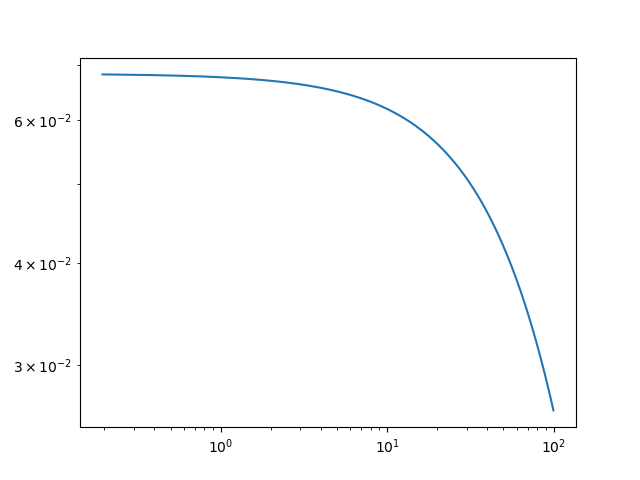

In [4]:
def spectrum_fit(freq: float | np.ndarray, scale: float, freq_corner: float, power:float) -> float | np.ndarray:
    return scale * (1 + ((freq+freq_corner)/freq_corner)) ** (-power)
    # return scale * np.exp(-power*(freq/freq_corner))

plt.figure()
plt.plot(pos_freq, spectrum_fit(pos_freq,70,500,10))
plt.loglog()

2.47343293971481
8.755957569927059
10.57816203258421
9.148638492263618
10.894363419297171
9.885902341502652
6.415260092206155
5.515564729930638


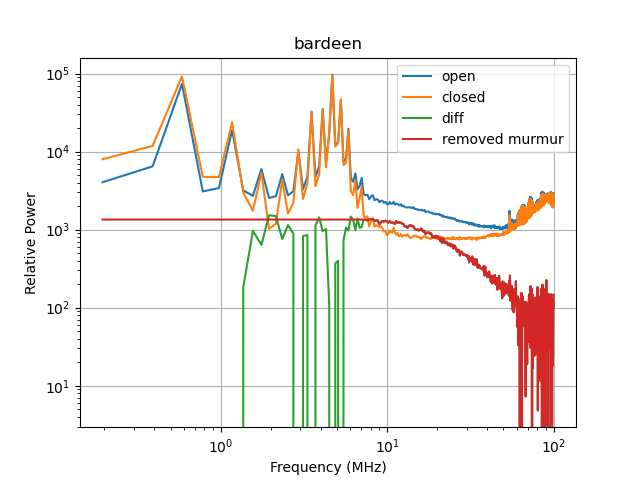

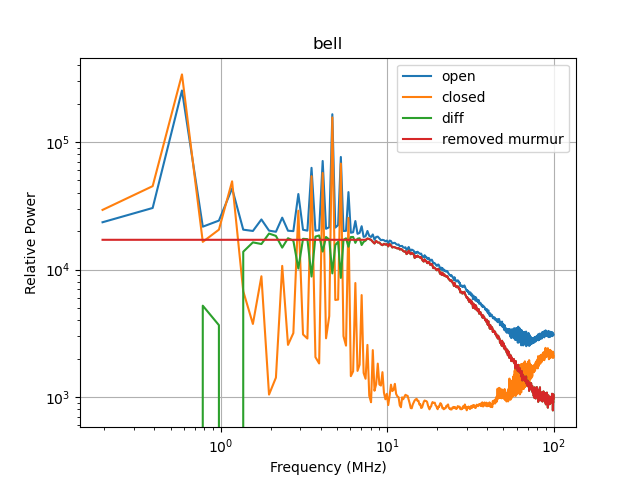

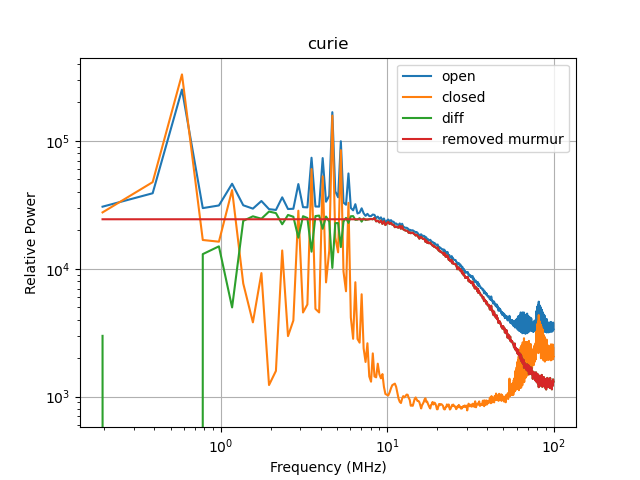

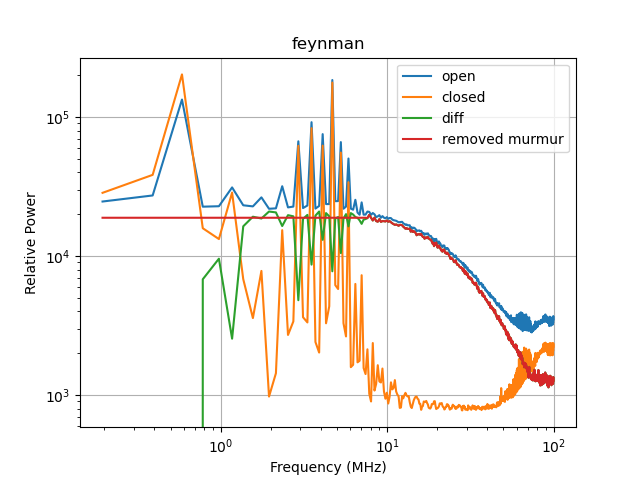

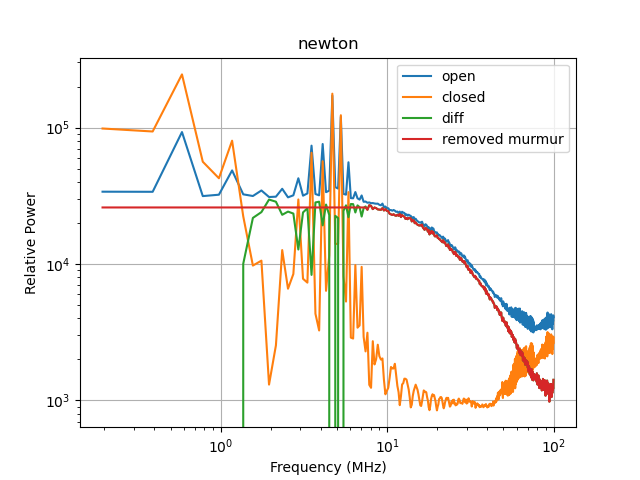

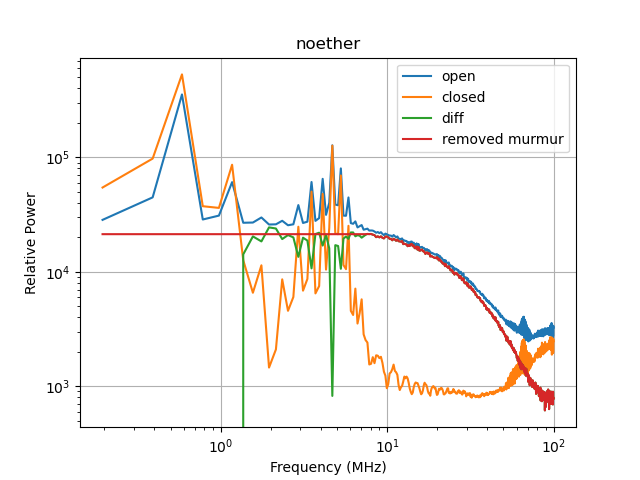

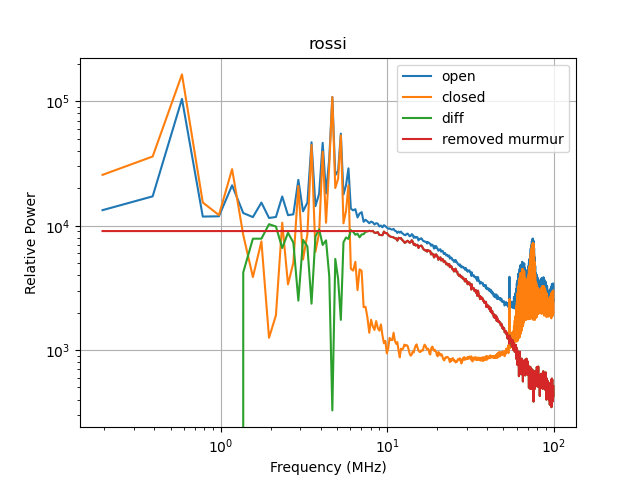

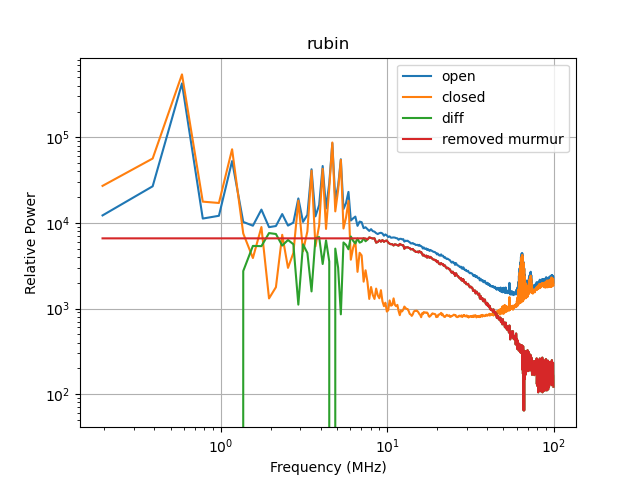

In [5]:


for counter in counters:
    plt.figure()
    # guess = (diff_dict[counter][freq>0.].max(),500,5)
    # popt, pcov = curve_fit(spectrum_fit, pos_freq[:endi], removed_murmur[:endi],p0=guess)
    # plt.plot(pos_freq, spectrum_fit(pos_freq,*popt), label = 'fit')
    print(np.sqrt(diff_dict[counter][freq>0.].max()/250))
    plt.plot(freq[freq>0.], noise_open_dict[counter][freq>0.], label = 'open')
    plt.plot(freq[freq>0.], noise_closed_dict[counter][freq>0.], label = 'closed')
    plt.plot(freq[freq>0.], diff_dict[counter][freq>0.], label = 'diff')
    plt.plot(freq[freq>0.], removed_murmur_dict[counter][freq>0.], label = 'removed murmur')
    plt.legend()
    plt.title(counter)
    plt.loglog()
    plt.grid()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Relative Power')

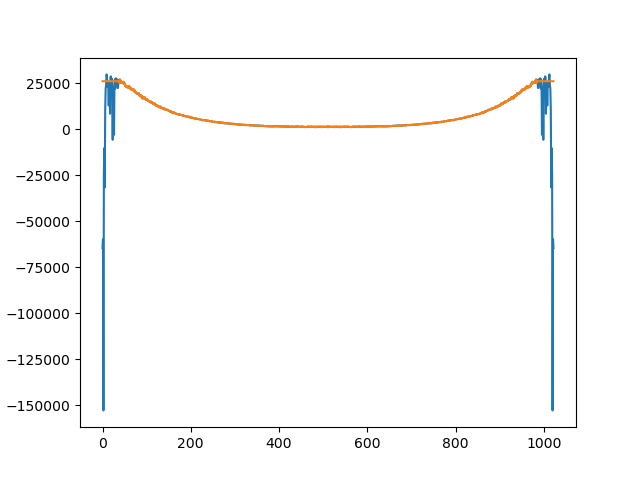

In [6]:
plt.figure()
plt.plot(diff_dict['newton'][1:])
plt.plot(removed_murmur_dict['newton'][1:])

In [7]:
gains = {'bardeen': 2.1882036884651583,
 'bell': 7.406880637204029,
 'curie': 9.561962861718685,
 'feynman': 7.734872492963433,
 'newton': 11.281268225032628,
 'noether': 9.834954480425155,
 'rossi': 5.1908236939723436,
 'rubin': 5.783684658654795,
 'rutherford': 8.852228215755146}

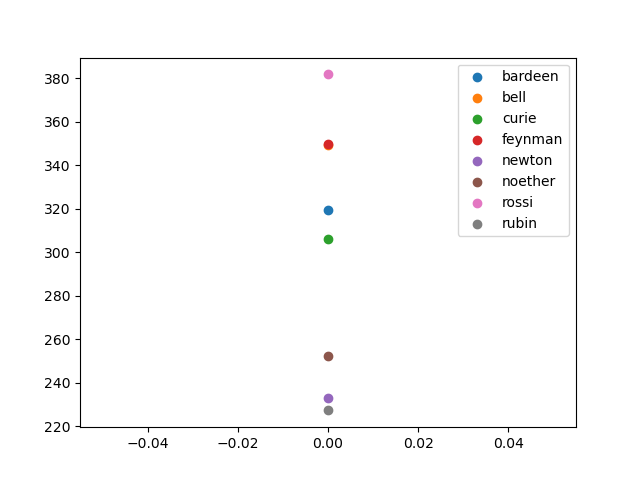

In [8]:
plt.figure()
for counter in counters:
    plt.scatter(0,diff_dict[counter][freq>0.].max()/gains[counter]**2,label=counter)
plt.legend()

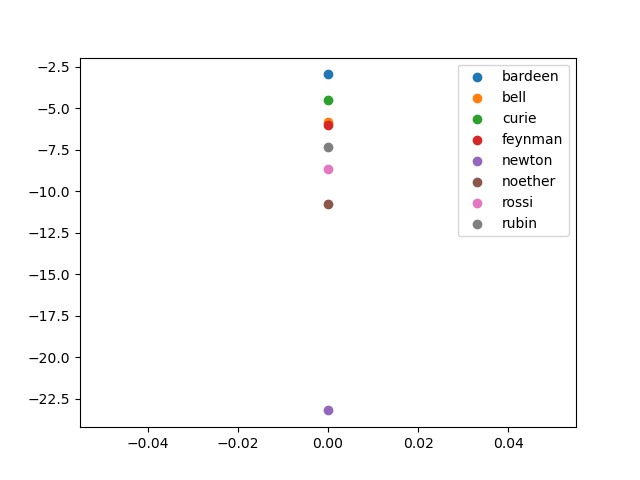

In [9]:
plt.figure()
for counter in counters:
    nsbg = (np.var(fadc_open_dict[counter]) - np.var(fadc_closed_dict[counter]))/gains[counter]
    plt.scatter(0,nsbg,label=counter)
plt.legend()

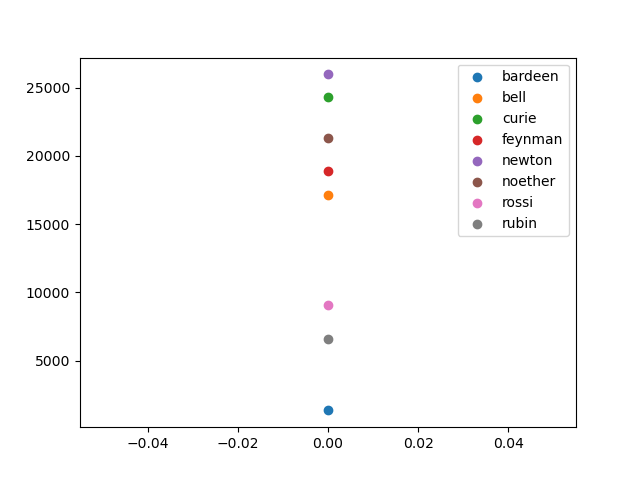

In [10]:
plt.figure()
for counter in counters:
    plt.scatter(0,removed_murmur_dict[counter][1],label=counter)
plt.legend()

In [11]:
nsbg = np.array([diff_dict[counter][freq>0.].max()/gains[counter]**2 for counter in counters])

In [12]:
nsbg.mean()

302.4301094055382

In [13]:
A = .0077 #m^2
niche_omega =4*np.pi*np.sin(np.radians(45/2))**2

In [14]:
niche_omega

1.8403023690212201

In [15]:
np.mean(nsbg*5.*A*niche_omega)

21.427669601890813

In [16]:
(3/.27/.9/.9)*100*4*(4*np.pi*np.sin(np.radians(.5))**2)

5.250806889299593

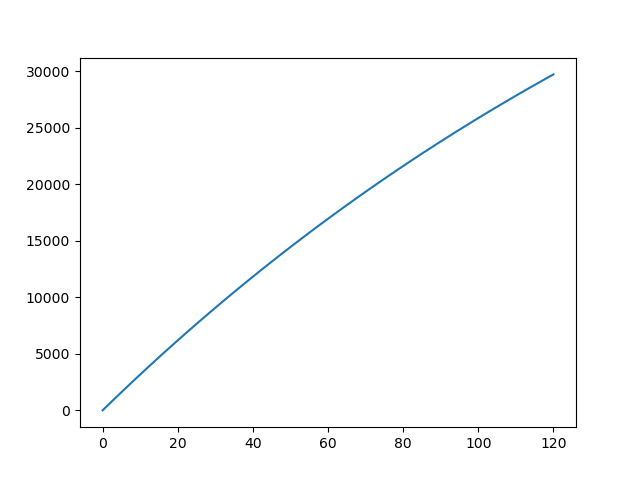

In [17]:
thetac = np.arctan(np.sqrt(77/np.pi)/62.)
frac = (1-np.cos(thetac)**5)

def e_output(amp: float | np.ndarray, a: float, b: float) -> float | np.ndarray:
    return a * (1 - np.exp(-amp/b))
planck = 6.62607015e-34
def nphotons(amp: float | np.ndarray) -> float | np.ndarray:
    return 1.e-12 * e_output(amp,488.095,211.949) / (planck * (3e8/355e-9))

amps = np.linspace(0,120,100)
plt.figure()
plt.plot(amps,frac * .005 * nphotons(amps))